# **Predictive Modeling for Insurance Risk and Premium Optimization**

This notebook implements: "Build and evaluate predictive models that form the core of a dynamic, risk-based pricing system." We will focus on two primary modeling goals: predicting `Claim Severity` and exploring approaches for `Premium Optimization`.

## **Table of Contents**

1. [Setup and Data Loading](#1-setup-and-data-loading)
2. [Data Preparation](#2-data-preparation)
    - 2.1. Initial Data Loading and Cleaning
    - 2.2. Feature Engineering
    - 2.3. Encoding Categorical Data & Scaling Numerical Data
    - 2.4. Train-Test Split
3. [Modeling Goal 1: Claim Severity Prediction (Risk Model)](#3-modeling-goal-1-claim-severity-prediction-risk-model)
    - 3.1. Model Building & Training
    - 3.2. Model Evaluation
    - 3.3. Model Interpretability (SHAP & LIME)
4. [Modeling Goal 2: Premium Optimization (Pricing Framework)](#4-modeling-goal-2-premium-optimization-pricing-framework)
    - 4.1. Conceptual Framework: Risk-Based Premium
    - 4.2. Model Building: Probability of Claim (Classification Model)
    - 4.3. Model Evaluation: Probability of Claim
    - 4.4. Model Interpretability (SHAP & LIME) for Probability Model
    - 4.5. Simplified Premium Prediction (Direct Regression on TotalPremium)
5. [Overall Model Comparison and Interpretation](#5-overall-model-comparison-and-interpretation)
6. [Conclusion and Business Recommendations](#6-conclusion-and-business-recommendations)

## **1. Setup and Data Loading**

We begin by importing all necessary libraries and our custom modular functions for data loading, preprocessing, and modeling. We'll load the processed data from Task 1, which should be available in `data/processed/`.

### Import necessary libraries

In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import shap
import lime
import lime.lime_tabular
import warnings

In [12]:
# Suppress specific warnings from libraries for cleaner output
warnings.filterwarnings('ignore', category=UserWarning, module='shap')
warnings.filterwarnings('ignore', category=FutureWarning, module='shap')
warnings.filterwarnings('ignore', message=".*The 'nopython' keyword argument was not supplied to the 'jit' decorator.*")
warnings.filterwarnings('ignore', message=".*XGBoost warning: `use_label_encoder` is deprecated.*")


### Setp plotting style

In [13]:
# Suppress specific warnings from libraries like shap for cleaner output
warnings.filterwarnings('ignore', category=UserWarning, module='shap')
warnings.filterwarnings('ignore', category=FutureWarning, module='shap')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['font.family'] = 'Inter'

### Import modules

In [14]:
# Add project root to sys.path to enable importing modular scripts
import sys
# Dynamically determine project root
current_path = Path.cwd()
if current_path.name == "notebooks":
    project_root = current_path.parent
else:
    project_root = current_path # Assume running from project root

if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Import data handling utilities
from src.utils.data_loader import load_data # Now handled by DataPreprocessor.load_and_clean_data

# Import new data preparation utilities
from src.utils.data_preparation.preprocessor import DataPreprocessor
from src.utils.data_preparation.feature_engineer import create_time_features, create_risk_ratio_features, create_vehicle_age_feature

# Import modeling utilities
from src.models.model_trainer import ModelTrainer
from src.models.linear_regression_strategy import LinearRegressionStrategy
from src.models.random_forest_strategy import RandomForestStrategy
from src.models.decision_tree_strategy import DecisionTreeStrategy # New
from src.models.xgboost_strategy import XGBoostStrategy
from src.models.model_evaluator import evaluate_regression_model, evaluate_classification_model
from src.models.model_interpreter import ModelInterpreter

# Import metrics calculator from  for HasClaim and Margin
from src.utils.hypothesis_testing.metrics_calculator import calculate_claim_frequency, calculate_margin

### Load and Preprocss Data

In [15]:
# Define paths for data files
raw_data_path = project_root / "data" / "raw" / "temp_extracted_data" / "MachineLearningRating_v3.txt"
partially_processed_data_path = project_root / "data" / "processed" / "processed_insurance_data.csv"
fully_processed_data_path = project_root / "data" / "processed" / "fully_processed_insurance_data.csv"

df_processed_for_modeling = pd.DataFrame() # This will hold the final, ready-for-model DataFrame
df_raw_or_partially_processed = pd.DataFrame() # This will hold data that needs further processing in later sections
pipeline_required = False # Flag to control subsequent preprocessing sections

# --- Intelligent Data Loading Strategy ---
print("\n--- Data Loading and Initial Processing ---")

# Attempt 1: Load fully processed data
print(f"Attempting to load fully preprocessed data from: {fully_processed_data_path}")
try:
    if fully_processed_data_path.is_file():
        df_processed_for_modeling = load_data(fully_processed_data_path, delimiter=',')
        if not df_processed_for_modeling.empty:
            print("--- Loaded fully preprocessed data. Skipping further preprocessing steps. ---")
        else:
            print(f"Warning: Fully processed data file '{fully_processed_data_path}' is empty or invalid. Proceeding to partial reprocessing.")
            pipeline_required = True # Set flag if fully processed data couldn't be loaded
    else:
        print(f"Fully processed data not found at: {fully_processed_data_path}. Proceeding to partial reprocessing.")
        pipeline_required = True # Set flag if fully processed file doesn't exist
except Exception as e:
    print(f"Error loading fully processed data from {fully_processed_data_path}: {e}. Proceeding to partial reprocessing.")
    pipeline_required = True # Set flag on error during fully processed load

# If fully processed data was not loaded successfully, attempt to load partially processed or raw
if pipeline_required: # Only proceed if pipeline is required
    # Attempt 2: Load partially processed data
    print(f"Attempting to load partially processed data from: {partially_processed_data_path}")
    try:
        if partially_processed_data_path.is_file():
            df_raw_or_partially_processed = DataPreprocessor.load_and_clean_data(partially_processed_data_path, delimiter=',') # Assuming this is a CSV now
            if not df_raw_or_partially_processed.empty:
                print("--- Loaded partially processed data. Will run feature engineering, initial data prep, cardinality, encoding/scaling. ---")
            else:
                print(f"Warning: Partially processed data file '{partially_processed_data_path}' is empty or invalid. Proceeding to raw data load.")
        else:
            print(f"Partially processed data not found at: {partially_processed_data_path}. Proceeding to raw data load.")
    except Exception as e:
        print(f"Error loading partially processed data from {partially_processed_data_path}: {e}. Proceeding to raw data load.")

    # If neither fully nor partially processed data was loaded, attempt to load raw data
    if df_raw_or_partially_processed.empty:
        print(f"Attempting to load raw data from: {raw_data_path}")
        if not raw_data_path.is_file():
            raise FileNotFoundError(f"Raw data file not found at: {raw_data_path}. Cannot proceed without data.")

        df_raw_or_partially_processed = DataPreprocessor.load_and_clean_data(raw_data_path, delimiter='|', file_type='txt')
        if df_raw_or_partially_processed.empty:
            raise ValueError(f"Raw DataFrame is empty after loading and initial cleaning from '{raw_data_path}'. Cannot proceed.")
        print("--- Loaded raw data. Will run full preprocessing pipeline. ---")
    else:
        # If df_raw_or_partially_processed was loaded from a partially processed file, save it as is
        # for consistency with the raw loading pathway for the rest of the pipeline.
        DataPreprocessor.save_dataframe(df_raw_or_partially_processed, partially_processed_data_path, index=False)


# Final check before proceeding with analysis
if df_processed_for_modeling.empty and df_raw_or_partially_processed.empty:
    raise ValueError("\nNo DataFrame loaded. Cannot proceed with analysis. Please check data paths and content.")

# If fully processed data was loaded, no need for the pipeline_required branches below.
# If df_processed_for_modeling is still empty here, it means pipeline_required is True
# and df_raw_or_partially_processed holds the data to be processed.
if df_processed_for_modeling.empty and not df_raw_or_partially_processed.empty:
    print(f"\nStarting point for pipeline: df_raw_or_partially_processed shape: {df_raw_or_partially_processed.shape}")
    # df_intermediate_pipeline will be passed through sections 2.1 to 2.4
    df_intermediate_pipeline = df_raw_or_partially_processed.copy()
else:
    print(f"\nLoaded fully processed data. Final DataFrame shape: {df_processed_for_modeling.shape}")

# Initialize final_model_feature_names here, will be updated in Section 2.4 if pipeline runs
final_model_feature_names = []

print("\n--- Data Loading and Initial Determination Complete ---")


--- Data Loading and Initial Processing ---
Attempting to load fully preprocessed data from: /home/micha/Downloads/course/10-accademy/week-3/Insurance-Risk-Analytics-and-Predictive-Modeling/data/processed/fully_processed_insurance_data.csv
Successfully loaded data from /home/micha/Downloads/course/10-accademy/week-3/Insurance-Risk-Analytics-and-Predictive-Modeling/data/processed/fully_processed_insurance_data.csv. Shape: (1000098, 60)
--- Loaded fully preprocessed data. Skipping further preprocessing steps. ---

Loaded fully processed data. Final DataFrame shape: (1000098, 60)

--- Data Loading and Initial Determination Complete ---


## **2. Data Preparation**

This phase is critical for transforming the raw or initially processed data into a format suitable for machine learning models. It involves handling missing values, creating new informative features, encoding categorical variables, and splitting the data for training and testing.

### **2.1. Initial Data Loading and Cleaning**

This step (already performed in section 1) ensures duplicates are removed and critical financial columns `TotalPremium`, `TotalClaims` are properly loaded and `NaN`s are filled with 0. Further imputation for other features will be handled by the `DataPreprocessor`'s pipeline.

In [16]:
print("\n--- 2.1. Initial Data Processing (Conditional) ---")
if pipeline_required:
    if df_intermediate_pipeline.empty:
        print("Skipping 2.1: df_intermediate_pipeline is empty. Cannot proceed with initial data processing.")
    else:
        print("Executing initial data processing steps as pipeline is required.")
        
        # Add 'HasClaim' and 'Margin' columns from Task 3 metrics calculator
        # These are derived features and logically fit well here.
        df_intermediate_pipeline = calculate_claim_frequency(df_intermediate_pipeline.copy())
        df_intermediate_pipeline = calculate_margin(df_intermediate_pipeline.copy())
        print("\nDataFrame head after initial metric calculation:")
        print(df_intermediate_pipeline.head())

        # --- Check for NaN values after calculating HasClaim and Margin ---
        nan_check_after_metrics = df_intermediate_pipeline.isnull().sum()
        nans_after_metrics = nan_check_after_metrics[nan_check_after_metrics > 0]
        if not nans_after_metrics.empty:
            print("\nWarning: NaN values detected in df_intermediate_pipeline AFTER calculating HasClaim and Margin (before general NaN dropping):")
            print(nans_after_metrics.sort_values(ascending=False))
        else:
            print("\nNo NaN values detected in df_intermediate_pipeline after calculating HasClaim and Margin.")
        # --- End of NaN check ---

        # Apply initial data preparation (type conversions, NaN dropping)
        print("\n--- Applying DataPreprocessor.apply_initial_data_preparation ---")
        df_intermediate_pipeline = DataPreprocessor.apply_initial_data_preparation(df_intermediate_pipeline.copy())
        
        # Check if DataFrame became empty after initial data preparation
        if df_intermediate_pipeline.empty:
            print("Warning: df_intermediate_pipeline became empty after DataPreprocessor.apply_initial_data_preparation. Subsequent steps will be skipped.")
        else:
            print("\nDataFrame Info after initial data preparation (types corrected, NaNs dropped):")
            df_intermediate_pipeline.info()
            print("\nMissing values remaining after 2.1 Initial Data Processing:")
            display(df_intermediate_pipeline.isnull().sum()[df_intermediate_pipeline.isnull().sum() > 0].sort_values(ascending=False))
else:
    print("Skipping: Data was loaded fully preprocessed. Initial data processing already done.")





--- 2.1. Initial Data Processing (Conditional) ---
Skipping: Data was loaded fully preprocessed. Initial data processing already done.


### **2.2. Feature Engineering**

We'll create new features that might enhance model performance by capturing additional information or relationships from existing columns.

In [17]:
print("\n--- 2.2. Feature Engineering (Conditional) ---")
if pipeline_required:
    print("Executing Feature Engineering as pipeline is required.")
    
    df_intermediate_pipeline = create_time_features(df_intermediate_pipeline.copy(), 'TransactionMonth')
    if df_intermediate_pipeline.empty:
        raise ValueError("DataFrame became empty after creating time features. Cannot proceed with further Feature Engineering.")
    df_intermediate_pipeline = create_risk_ratio_features(df_intermediate_pipeline.copy())
    df_intermediate_pipeline = create_vehicle_age_feature(df_intermediate_pipeline.copy(), current_year=2025)
    print("\nDataFrame head after Feature Engineering:")
    display(df_intermediate_pipeline.head())
    print("\nDataFrame Info after Feature Engineering:")
    df_intermediate_pipeline.info()
else:
    print("Skipping: Data was loaded fully preprocessed. Feature engineering already done.")



--- 2.2. Feature Engineering (Conditional) ---
Skipping: Data was loaded fully preprocessed. Feature engineering already done.


### **2.3. Reduce High-Cardinality Features**
To prevent Out-of-Memory errors from one-hot encoding very high-cardinality features, we will reduce their uniqueness. For PostalCode, we'll truncate it. For Make and Model, we'll group rare categories into 'Other'.

In [18]:
print("\n--- 2.3. Reduce High-Cardinality Features (Conditional) ---")
if pipeline_required:
    print("Executing High Cardinality Reduction as pipeline is required.")
    
    all_current_categorical_cols = df_intermediate_pipeline.select_dtypes(include=['category', 'bool']).columns.tolist() # 'object' should be gone by now
    categorical_cols_for_cardinality_reduction = [
        'Make', 'Model', 'SubCrestaZone', 'MainCrestaZone', 'PostalCode',
        'Citizenship', 'LegalType', 'Bank', 'AccountType', 'MaritalStatus',
        'Product', 'Bodytype', 'CoverCategory', 'CoverType', 'CoverGroup',
        'Section', 'StatutoryClass', 'StatutoryRiskType', 'Title', 'Language',
        'MaritalStatus', 'Country', 'Province', 'VehicleType', 'Gender',
        'ItemType'
    ]
    categorical_cols_for_cardinality_reduction = [
        col for col in categorical_cols_for_cardinality_reduction
        if col in all_current_categorical_cols
    ]
    df_intermediate_pipeline = DataPreprocessor.reduce_high_cardinality_features(
        df_intermediate_pipeline.copy(),
        categorical_cols_to_reduce=categorical_cols_for_cardinality_reduction,
        postal_code_col='PostalCode',
        other_threshold_ratio=0.01
    )
    print("\nDataFrame head after High Cardinality Reduction:")
    print(df_intermediate_pipeline.head())
    print("\nUnique counts after High Cardinality Reduction (selected potentially high-cardinality columns):")
    for col in categorical_cols_for_cardinality_reduction:
        if col in df_intermediate_pipeline.columns:
            print(f"  {col}: {df_intermediate_pipeline[col].nunique()} unique values")
else:
    print("Skipping: Data was loaded fully preprocessed. High-cardinality reduction already done.")




--- 2.3. Reduce High-Cardinality Features (Conditional) ---
Skipping: Data was loaded fully preprocessed. High-cardinality reduction already done.


### **2.4. Encoding Categorical Data & Scaling Numerical Data**

We'll define the final set of features for our models and then use our `DataPreprocessor` to handle one-hot encoding for categorical features and standard scaling for numerical features. This is crucial as most machine learning models require numerical input and can perform better with scaled data.

In [19]:
print("\n--- 2.4. Encoding Categorical Data (Label Encoding) and Numerical Imputation & Scaling (Conditional) ---")
if pipeline_required:
    if df_intermediate_pipeline.empty:
        print("Skipping 2.4: df_intermediate_pipeline is empty from previous step. Cannot proceed with Encoding and Scaling.")
        # If pipeline_required is True but df_intermediate_pipeline is empty,
        # ensure df_processed_for_modeling is empty and final_model_feature_names is also empty.
        df_processed_for_modeling = pd.DataFrame()
        final_model_feature_names = []
    else:
        print("Executing Encoding and Scaling as pipeline is required.")
        print("Using Label Encoding for categorical features and Standard Scaling for numerical features.")
        print("Numerical features will be imputed with their mean values and then scaled.")
        print("Tree-based models (Decision Tree, Random Forest, XGBoost) are generally robust to Label Encoding for nominal features.")

        # Define columns that will be targets or IDs and should not be processed as features
        features_to_exclude_from_preprocessing = [
            'PolicyID', 'UnderwrittenCoverID', 'TotalClaims', 'TotalPremium',
            'HasClaim', 'Margin', 'TransactionMonth', 'VehicleIntroDate'
        ]
        
        # Capture target columns and other excluded columns before dropping them for preprocessing
        # This ensures we can re-attach them later.
        target_and_id_cols = df_intermediate_pipeline[
            [col for col in features_to_exclude_from_preprocessing if col in df_intermediate_pipeline.columns]
        ].copy()

        all_current_cols_final_prep = df_intermediate_pipeline.columns.tolist()
        
        # Identify numerical features: include all numerical columns *not* in the exclusion list
        # Removed the `and not df_intermediate_pipeline[col].isnull().all()` condition to ensure
        # all numerical columns are considered for imputation, even if entirely NaN initially.        
        final_numerical_features = [
            col for col in df_intermediate_pipeline.select_dtypes(include=np.number).columns.tolist()
            if col in all_current_cols_final_prep and col not in features_to_exclude_from_preprocessing and not df_intermediate_pipeline[col].isnull().all()
        ]
        # Identify categorical features: include all categorical/boolean columns *not* in the exclusion list
        final_categorical_features = [
            col for col in df_intermediate_pipeline.select_dtypes(include=['category', 'bool']).columns.tolist()
            if col in all_current_cols_final_prep and col not in features_to_exclude_from_preprocessing
        ]
        
        print(f"Features selected for final preprocessing: {len(final_numerical_features)} numerical, {len(final_categorical_features)} categorical.")
        print("Numerical Features for Preprocessor:", final_numerical_features)
        print("Categorical Features for Preprocessor:", final_categorical_features)

        # Drop target/ID columns for the preprocessor input
        df_pre_final_preprocessor = df_intermediate_pipeline.drop(
            columns=[col for col in features_to_exclude_from_preprocessing if col in df_intermediate_pipeline.columns],
            errors='ignore'
        ).copy()

        preprocessor = DataPreprocessor(
            numerical_cols=final_numerical_features,
            categorical_cols=final_categorical_features
        )
        df_processed_for_modeling = preprocessor.preprocess(
            df_pre_final_preprocessor,
            encoder_type='label',
            scaler_type='standard'
        )
        
        
        # --- NEW: Re-join target and ID columns to the processed DataFrame ---
        if not df_processed_for_modeling.empty and not target_and_id_cols.empty:
            # Ensure index alignment if merging based on index
            df_processed_for_modeling = pd.concat([df_processed_for_modeling.reset_index(drop=True), target_and_id_cols.reset_index(drop=True)], axis=1)
            print("\nRe-joined target and ID columns to df_processed_for_modeling.")
        elif not df_processed_for_modeling.empty and target_and_id_cols.empty:
            print("\nWarning: Target and ID columns were not available to re-join, df_processed_for_modeling contains only features.")
        else:
            print("\nWarning: df_processed_for_modeling is empty after preprocessing. Cannot re-join target columns.")


        # Final failsafe for datetime columns (should ideally not be needed if initial prep is robust)
        # if 'TransactionMonth' in df_processed_for_modeling.columns and pd.api.types.is_datetime64_any_dtype(df_processed_for_modeling['TransactionMonth']):
        print("  Failsafe: Final drop of 'TransactionMonth' (datetime type) from df_processed_for_modeling.")
        df_processed_for_modeling = df_processed_for_modeling.drop(columns=['TransactionMonth'])
        # if 'VehicleIntroDate' in df_processed_for_modeling.columns and pd.api.types.is_datetime64_any_dtype(df_processed_for_modeling['VehicleIntroDate']):
        print("  Failsafe: Final drop of 'VehicleIntroDate' (datetime type) from df_processed_for_modeling.")
        df_processed_for_modeling = df_processed_for_modeling.drop(columns=['VehicleIntroDate'])

        # Save the fully processed DataFrame
        print(f"\n--- Saving fully processed data to: {fully_processed_data_path} ---")
        DataPreprocessor.save_dataframe(df_processed_for_modeling, fully_processed_data_path, index=False)
        print("Full preprocessing pipeline completed and saved.")
else:
    print("Skipping: Data was loaded fully preprocessed. Encoding and scaling already done.")

# Ensure final_model_feature_names is always set based on the final df_processed_for_modeling
if not df_processed_for_modeling.empty:
    final_model_feature_names = [
        col for col in df_processed_for_modeling.columns
        if col not in ['TotalClaims', 'TotalPremium', 'HasClaim', 'Margin']
    ]
else:
    print("Warning: df_processed_for_modeling is empty. final_model_feature_names will be empty.")
    final_model_feature_names = []


print("\nFinal DataFrame for Modeling Info (df_processed_for_modeling):")
df_processed_for_modeling.info()
print("\nFinal DataFrame for Modeling Head (df_processed_for_modeling):\n")
display(df_processed_for_modeling.head())
print(f"\nTotal columns in final processed DataFrame after Label Encoding and Scaling: {df_processed_for_modeling.shape[1]}")

print("\nFinal feature names for models (first 10):", final_model_feature_names[:10], "...")



--- 2.4. Encoding Categorical Data (Label Encoding) and Numerical Imputation & Scaling (Conditional) ---
Skipping: Data was loaded fully preprocessed. Encoding and scaling already done.

Final DataFrame for Modeling Info (df_processed_for_modeling):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 60 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   IsVATRegistered           1000098 non-null  int64  
 1   Citizenship               1000098 non-null  int64  
 2   LegalType                 1000098 non-null  int64  
 3   Title                     1000098 non-null  int64  
 4   Language                  1000098 non-null  int64  
 5   Bank                      1000098 non-null  int64  
 6   AccountType               1000098 non-null  int64  
 7   MaritalStatus             1000098 non-null  int64  
 8   Gender                    1000098 non-null  int64  
 9   Coun

,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,MaritalStatus,Gender,Country,...,WeekOfYear,Quarter,ClaimPremiumRatio,VehicleAge,PolicyID,UnderwrittenCoverID,TotalClaims,TotalPremium,HasClaim,Margin
0,1,0,1,0,0,2,0,0,1,0,...,-0.974587,-1.300561,-0.007078,1.908809,12827,145249,0.0,21.929825,0,21.929825
1,1,0,1,0,0,2,0,0,1,0,...,-0.306252,-0.309099,-0.007078,1.908809,12827,145249,0.0,21.929825,0,21.929825
2,1,0,1,0,0,2,0,0,1,0,...,0.362084,0.682363,-0.007078,1.908809,12827,145249,0.0,0.000000,0,0.000000
3,1,0,1,0,0,2,0,0,1,0,...,-0.306252,-0.309099,-0.007078,1.908809,12827,145255,0.0,512.848070,0,512.848070
4,1,0,1,0,0,2,0,0,1,0,...,0.362084,0.682363,-0.007078,1.908809,12827,145255,0.0,0.000000,0,0.000000



Total columns in final processed DataFrame after Label Encoding and Scaling: 60

Final feature names for models (first 10): ['IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country'] ...


### **2.4. Train-Test Split**

We will split the data into training and testing sets. A 70:30 ratio is common. This ensures we evaluate models on unseen data.

In [20]:
# Define features (X) and targets (y) for modeling
# X includes all processed features (numerical + Label Encoded)
# y includes the original target columns ('TotalClaims', 'HasClaim', 'TotalPremium')

X = df_processed_for_modeling[final_model_feature_names] # Use the identified final feature names
y_severity = df_processed_for_modeling['TotalClaims'] # Target for Claim Severity
y_probability = df_processed_for_modeling['HasClaim'] # Target for Claim Probability
y_premium = df_processed_for_modeling['TotalPremium'] # Target for Direct Premium Prediction

print(f"Features (X) shape: {X.shape}")
print(f"TotalClaims target (y_severity) shape: {y_severity.shape}")
print(f"HasClaim target (y_probability) shape: {y_probability.shape}")
print(f"TotalPremium target (y_premium) shape: {y_premium.shape}")

print("\n--- Checking dtypes of X before splitting ---")
X.info()
print("\n--- Detailed dtypes of X before splitting ---")
print(X.dtypes)

# Split the data into training and testing sets
# Use a common random_state for reproducibility
X_train, X_test, y_severity_train, y_severity_test = train_test_split(
    X, y_severity, test_size=0.3, random_state=42
)
_, _, y_probability_train, y_probability_test = train_test_split(
    X, y_probability, test_size=0.3, random_state=42, stratify=y_probability # Stratify for classification target
)
_, _, y_premium_train, y_premium_test = train_test_split(
    X, y_premium, test_size=0.3, random_state=42
)


print(f"\nTrain set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"X_train columns (first 5): {X_train.columns.tolist()[:5]}...")
print("\n--- Checking dtypes of X_train (severity) before training ---")
X_train[y_severity_train > 0].info() # Info for X_train_severity subset


Features (X) shape: (1000098, 56)
TotalClaims target (y_severity) shape: (1000098,)
HasClaim target (y_probability) shape: (1000098,)
TotalPremium target (y_premium) shape: (1000098,)

--- Checking dtypes of X before splitting ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 56 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   IsVATRegistered           1000098 non-null  int64  
 1   Citizenship               1000098 non-null  int64  
 2   LegalType                 1000098 non-null  int64  
 3   Title                     1000098 non-null  int64  
 4   Language                  1000098 non-null  int64  
 5   Bank                      1000098 non-null  int64  
 6   AccountType               1000098 non-null  int64  
 7   MaritalStatus             1000098 non-null  int64  
 8   Gender                    1000098 non-null  int64  
 9   Country                 

## **3. Modeling Goal 1: Claim Severity Prediction (Risk Model)**

For policies that have a claim (`TotalClaims > 0`), we build a regression model to predict the `TotalClaims` amount. This model is crucial for estimating the financial liability associated with a policy.

- **Target Variable**: `TotalClaims` (on the subset of data where claims > 0).
- **Evaluation Metric**: Root Mean Squared Error (RMSE) to penalize large prediction errors, and R-squared.


--- 3. Modeling Goal 1: Claim Severity Prediction ---

Claim Severity Training Data Shape (claims > 0): (1905, 56), (1905,)
Claim Severity Test Data Shape (claims > 0): (883, 56), (883,)

--- Debugging X_train_severity dtypes and NaNs BEFORE training models ---
<class 'pandas.core.frame.DataFrame'>
Index: 1905 entries, 811228 to 861882
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   IsVATRegistered           1905 non-null   int64  
 1   Citizenship               1905 non-null   int64  
 2   LegalType                 1905 non-null   int64  
 3   Title                     1905 non-null   int64  
 4   Language                  1905 non-null   int64  
 5   Bank                      1905 non-null   int64  
 6   AccountType               1905 non-null   int64  
 7   MaritalStatus             1905 non-null   int64  
 8   Gender                    1905 non-null   int64  
 9   Country           

NumberOfVehiclesInFleet    1905
TermFrequency              1905
ExcessSelected             1905
dtype: int64

Attempting to fill remaining NaNs in X_train_severity with 0 (for numerical columns).
NaNs in X_train_severity after fillna(0) attempt:
Series([], dtype: int64)

--- Debugging X_test_severity dtypes and NaNs BEFORE prediction ---
<class 'pandas.core.frame.DataFrame'>
Index: 883 entries, 353164 to 123718
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   IsVATRegistered           883 non-null    int64  
 1   Citizenship               883 non-null    int64  
 2   LegalType                 883 non-null    int64  
 3   Title                     883 non-null    int64  
 4   Language                  883 non-null    int64  
 5   Bank                      883 non-null    int64  
 6   AccountType               883 non-null    int64  
 7   MaritalStatus             883 non-null    int64  
 8   Gender                    883 non-null    int64  
 9   Country                   883 non-null    int64  
 1

/tmp/ipykernel_49803/623711554.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_severity[col] = X_train_severity[col].fillna(0)


NumberOfVehiclesInFleet    883
TermFrequency              883
ExcessSelected             883
dtype: int64

Attempting to fill remaining NaNs in X_test_severity with 0 (for numerical columns).
NaNs in X_test_severity after fillna(0) attempt:
Series([], dtype: int64)
------------------------------------------------------------------

--- Training Linear Regression for Claim Severity ---
--- Training Model: Linear Regression ---
Training Linear Regression model...


/tmp/ipykernel_49803/623711554.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_severity[col] = X_test_severity[col].fillna(0)


Linear Regression training complete.
Model 'Linear Regression' trained.
--- Generating Predictions with: Linear Regression ---
Predictions generated for 883 samples.
  RMSE: 30996.5897
  R-squared: 0.2617

--- Training Decision Tree Regressor for Claim Severity ---
--- Training Model: Decision Tree Regressor ---
Training Decision Tree Regressor model...
Decision Tree Regressor training complete.
Model 'Decision Tree Regressor' trained.
--- Generating Predictions with: Decision Tree Regressor ---
Predictions generated for 883 samples.
  RMSE: 47045.9257
  R-squared: -0.7007

--- Training Random Forest for Claim Severity ---
--- Training Model: Random Forest Regressor ---
Training Random Forest Regressor model...
Random Forest Regressor training complete.
Model 'Random Forest Regressor' trained.
--- Generating Predictions with: Random Forest Regressor ---
Predictions generated for 883 samples.
  RMSE: 31652.0590
  R-squared: 0.2302

--- Training XGBoost Regressor for Claim Severity ---
-

,RMSE,R-squared
Linear Regression,30996.589742,0.261717
Random Forest,31652.059025,0.230163
XGBoost Regressor,37003.483632,-0.052156
Decision Tree,47045.925724,-0.700744


Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



Best performing Claim Severity model based on RMSE: Linear Regression

--- Model Interpretability for Linear Regression (Claim Severity) ---
Initializing KernelExplainer for SHAP (model-agnostic, can be slower).
Sampling KernelExplainer background data from 1905 to 500 instances to reduce memory usage.
Generating SHAP explanations for 883 instances...


  0%|          | 0/883 [00:00<?, ?it/s]

SHAP values generated.

SHAP Summary Plot (Global Feature Importance for Claim Severity):
Displaying SHAP summary plot...


findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font f

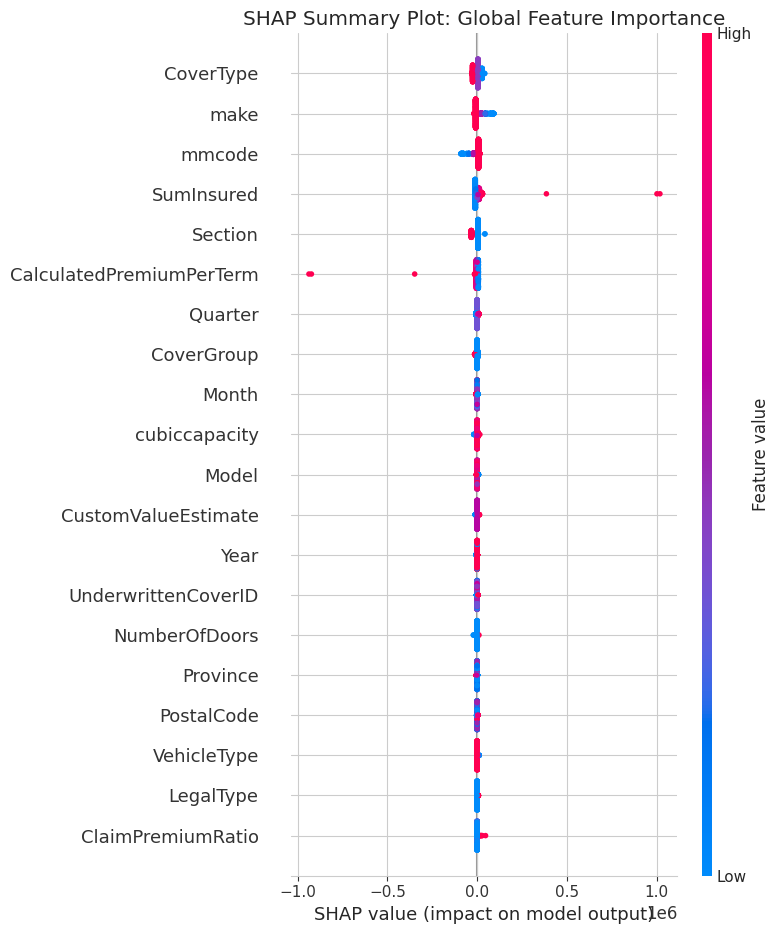


LIME Explanation for a Sample Prediction (first instance in test set):
Generating LIME explanation for instance (first few features):
IsVATRegistered    0.0
Citizenship        0.0
LegalType          0.0
Title              0.0
Language           0.0
Sampling LIME background data from 1905 to 1000 instances to reduce memory usage.


/home/micha/Downloads/course/10-accademy/week-3/Insurance-Risk-Analytics-and-Predictive-Modeling/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(



LIME Explanation (Feature Contribution to Prediction):
  8.00 < CoverType <= 12.00: -35780.6092
  Section <= 1.00: 35705.9858
  make <= 42.00: 28470.8314
  CalculatedPremiumPerTerm <= -0.23: 26347.1556
  IsVATRegistered <= 0.00: 22516.2415
  MaritalStatus <= 0.00: 20904.1241
  CoverGroup <= 2.00: 20846.7405
  SumInsured <= -0.40: 15134.8793
  0.38 < mmcode <= 0.38: 13382.3215
  ClaimPremiumRatio <= -0.01: -10361.0661


findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font f

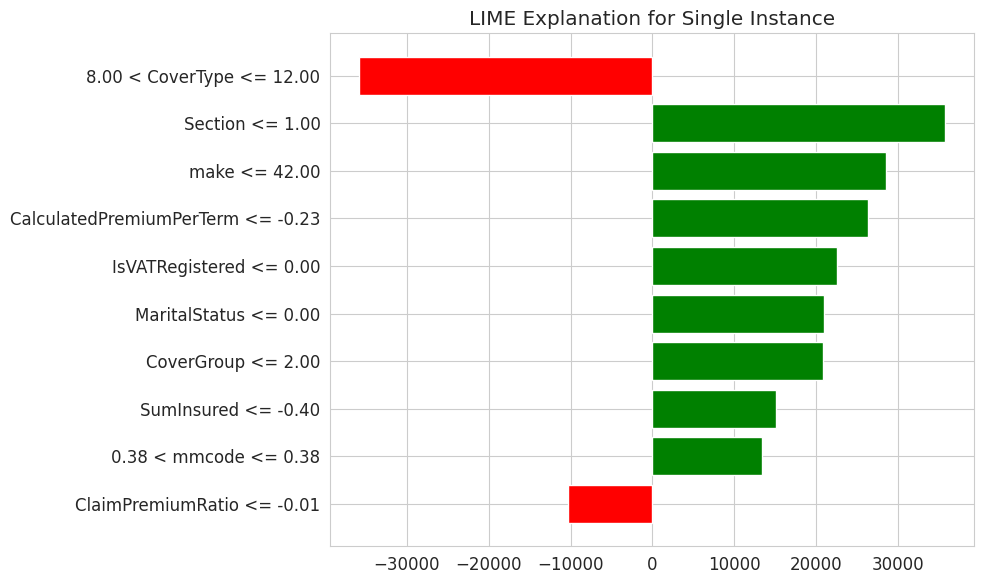

In [22]:
print("\n--- 3. Modeling Goal 1: Claim Severity Prediction ---\n")

# Filter data for policies with actual claims (Claim Severity is for WHEN a claim occurs)
# Ensure X and y align after filtering
claims_mask_train = (y_severity_train > 0)
X_train_severity = X_train[claims_mask_train]
y_train_severity = y_severity_train[claims_mask_train]

claims_mask_test = (y_severity_test > 0)
X_test_severity = X_test[claims_mask_test]
y_test_severity = y_severity_test[claims_mask_test]

print(f"Claim Severity Training Data Shape (claims > 0): {X_train_severity.shape}, {y_train_severity.shape}")
print(f"Claim Severity Test Data Shape (claims > 0): {X_test_severity.shape}, {y_test_severity.shape}")

# --- IMPORTANT DEBUGGING AND NaN HANDLING STEP for Claim Severity ---
print("\n--- Debugging X_train_severity dtypes and NaNs BEFORE training models ---")
X_train_severity.info()
nans_in_X_train_severity = X_train_severity.isnull().sum()
nans_in_X_train_severity = nans_in_X_train_severity[nans_in_X_train_severity > 0]
if not nans_in_X_train_severity.empty:
    print("\nWARNING: NaN values still present in X_train_severity! Details below:")
    display(nans_in_X_train_severity.sort_values(ascending=False))
    # --- PROPOSED FIX: Fill remaining NaNs for robust model training ---
    print("Attempting to fill remaining NaNs in X_train_severity with 0 (for numerical columns).")
    for col in nans_in_X_train_severity.index:
        if pd.api.types.is_numeric_dtype(X_train_severity[col]):
            X_train_severity[col] = X_train_severity[col].fillna(0)
        else:
            print(f"  Note: Column '{col}' with NaNs is not numeric. Skipping fillna(0).")
    print("NaNs in X_train_severity after fillna(0) attempt:")
    print(X_train_severity.isnull().sum()[X_train_severity.isnull().sum() > 0])
else:
    print("No NaN values detected in X_train_severity after all preprocessing. Proceeding.")

print("\n--- Debugging X_test_severity dtypes and NaNs BEFORE prediction ---")
X_test_severity.info()
nans_in_X_test_severity = X_test_severity.isnull().sum()
nans_in_X_test_severity = nans_in_X_test_severity[nans_in_X_test_severity > 0]
if not nans_in_X_test_severity.empty:
    print("\nWARNING: NaN values still present in X_test_severity! Details below:")
    display(nans_in_X_test_severity.sort_values(ascending=False))
    # --- PROPOSED FIX: Fill remaining NaNs for robust model prediction ---
    print("Attempting to fill remaining NaNs in X_test_severity with 0 (for numerical columns).")
    for col in nans_in_X_test_severity.index:
        if pd.api.types.is_numeric_dtype(X_test_severity[col]):
            X_test_severity[col] = X_test_severity[col].fillna(0)
        else:
            print(f"  Note: Column '{col}' with NaNs is not numeric. Skipping fillna(0).")
    print("NaNs in X_test_severity after fillna(0) attempt:")
    print(X_test_severity.isnull().sum()[X_test_severity.isnull().sum() > 0])
else:
    print("No NaN values detected in X_test_severity after all preprocessing. Proceeding.")
print("------------------------------------------------------------------")


if X_train_severity.empty or y_train_severity.empty or X_test_severity.empty or y_test_severity.empty:
    print("Warning: Insufficient data for Claim Severity prediction (very few or no claims with value > 0). Skipping this section.")
else:
    # Dictionary to store model evaluation results for comparison
    severity_model_results = {}

    # Initialize ModelTrainer
    trainer = ModelTrainer(LinearRegressionStrategy()) # Start with LR

    # --- 3.1. Model Building & Training ---

    # Model 1: Linear Regression for Claim Severity
    print("\n--- Training Linear Regression for Claim Severity ---")
    trainer.train_model(X_train_severity, y_train_severity)
    lr_severity_predictions = trainer.predict_model(X_test_severity)
    lr_severity_model = trainer.get_current_model_object()
    severity_model_results['Linear Regression'] = evaluate_regression_model(y_test_severity, lr_severity_predictions)


    # Model 2: Decision Tree for Claim Severity (NEW)
    print("\n--- Training Decision Tree Regressor for Claim Severity ---")
    trainer.set_strategy(DecisionTreeStrategy(model_type='regressor', random_state=42))
    trainer.train_model(X_train_severity, y_train_severity)
    dt_severity_predictions = trainer.predict_model(X_test_severity)
    dt_severity_model = trainer.get_current_model_object()
    severity_model_results['Decision Tree'] = evaluate_regression_model(y_test_severity, dt_severity_predictions)


    # Model 3: Random Forest for Claim Severity
    print("\n--- Training Random Forest for Claim Severity ---")
    trainer.set_strategy(RandomForestStrategy(n_estimators=200, random_state=42))
    trainer.train_model(X_train_severity, y_train_severity)
    rf_severity_predictions = trainer.predict_model(X_test_severity)
    rf_severity_model = trainer.get_current_model_object()
    severity_model_results['Random Forest'] = evaluate_regression_model(y_test_severity, rf_severity_predictions)


    # Model 4: XGBoost for Claim Severity
    print("\n--- Training XGBoost Regressor for Claim Severity ---")
    trainer.set_strategy(XGBoostStrategy(objective='reg:squarederror', n_estimators=200, random_state=42))
    trainer.train_model(X_train_severity, y_train_severity)
    xgb_severity_predictions = trainer.predict_model(X_test_severity)
    xgb_severity_model = trainer.get_current_model_object()
    severity_model_results['XGBoost Regressor'] = evaluate_regression_model(y_test_severity, xgb_severity_predictions)


    # --- 3.2. Model Evaluation (Consolidated) ---
    print("\n--- Claim Severity Model Comparison ---")
    severity_comparison_df = pd.DataFrame(severity_model_results).T
    display(severity_comparison_df.sort_values(by='RMSE')) # Sort by RMSE to find best performing

    # Identify the best performing model based on RMSE
    best_severity_model_name = severity_comparison_df['RMSE'].idxmin()
    print(f"\nBest performing Claim Severity model based on RMSE: {best_severity_model_name}")

    # Select the best model object for interpretability
    best_severity_model = {
        'Linear Regression': lr_severity_model,
        'Decision Tree': dt_severity_model,
        'Random Forest': rf_severity_model,
        'XGBoost Regressor': xgb_severity_model
    }.get(best_severity_model_name)

    # --- 3.3. Model Interpretability (SHAP & LIME) ---
    if best_severity_model and not X_test_severity.empty:
        print(f"\n--- Model Interpretability for {best_severity_model_name} (Claim Severity) ---")

        # Initialize ModelInterpreter with the best model and features for SHAP/LIME
        # Pass `X_train_severity.values` for LIME background data.
        # Adjust `max_background_samples_shap` if SHAP still causes MemoryErrors for non-tree models.
        # `max_background_samples_lime` now explicitly controls LIME's internal sampling.
        interpreter_severity = ModelInterpreter(
            model=best_severity_model,
            feature_names=X_test_severity.columns.tolist(),
            model_type='regression',
            training_data_for_lime=X_train_severity.values, # Pass the actual training data for LIME
            max_background_samples_shap=500, # Adjust if MemoryError occurs during SHAP for non-tree models
            max_background_samples_lime=1000 # Max samples for LIME's internal background data
        )
        
        # SHAP for overall feature importance
        # Use a subset of X_test_severity for SHAP explanation if dataset is large,
        # as KernelExplainer can be computationally intensive. TreeExplainer is faster.
        shap_X_severity = X_test_severity.sample(min(1000, len(X_test_severity)), random_state=42) if len(X_test_severity) > 1000 else X_test_severity

        interpreter_severity.explain_model_shap(shap_X_severity)
        print("\nSHAP Summary Plot (Global Feature Importance for Claim Severity):")
        interpreter_severity.plot_shap_summary(shap_X_severity)

        # LIME for individual instance explanation
        print("\nLIME Explanation for a Sample Prediction (first instance in test set):")
        # The ModelInterpreter's explain_instance_lime method uses the training_data_for_lime
        # provided during initialization, which is now internally sampled.
        interpreter_severity.explain_instance_lime(X_test_severity.iloc[0])

    else:
        print("Skipping model interpretability for Claim Severity due to insufficient data or no best model found.")


## **4. Modeling Goal 2: Premium Optimization (Pricing Framework)**

The ultimate goal is a dynamic, risk-based pricing system. This involves predicting the probability of a claim and its severity.

### **4.1. Conceptual Framework: Risk-Based Premium**

The prompt outlines a sophisticated approach for a Risk-Based Premium:

Premium = (Predicted Probability of Claim * Predicted Claim Severity) + Expense Loading + Profit Margin

This formula suggests a two-stage modeling approach:

1. **Probability of Claim Model**: A classification model predicts `P(Claim = 1)`.
2. **Claim Severity Model**: A regression model (which we just built) predicts `E[TotalClaims | Claim = 1]`.

We then combine these with business-defined "Expense Loading" (costs of operations, sales, etc.) and "Profit Margin" to arrive at a recommended premium.

### **4.2. Model Building: Probability of Claim (Classification Model)**

We will build a binary classification model to predict `HasClaim` (0 or 1).

- **Target Variable**: `HasClaim`.
- **Evaluation Metric**: Accuracy, Precision, Recall, F1-score.

In [23]:
print("\n--- 4.2. Model Building: Probability of Claim (Classification Model) ---")

# For classification, we use y_probability_train and y_probability_test
# Ensure that the target column 'HasClaim' is suitable for classification (binary: 0 or 1)
print(f"Claim Probability Training Target Value Counts:\n{y_probability_train.value_counts()}")
print(f"Claim Probability Test Target Value Counts:\n{y_probability_test.value_counts()}")

# Check for class imbalance which is common in claim data
if not y_probability_train.empty and y_probability_train.value_counts().min() / y_probability_train.value_counts().max() < 0.2:
    print("Warning: Significant class imbalance detected in 'HasClaim'. Consider techniques like SMOTE or class weighting for training.")
else:
    print("Class distribution for 'HasClaim' appears balanced enough or data is too small to assess imbalance.")

# Dictionary to store classification model evaluation results
probability_model_results = {}

# Initialize ModelTrainer
trainer_clf = ModelTrainer(DecisionTreeStrategy(model_type='classifier', random_state=42)) # Start with DT Classifier



--- 4.2. Model Building: Probability of Claim (Classification Model) ---
Claim Probability Training Target Value Counts:
HasClaim
0    698116
1      1952
Name: count, dtype: int64
Claim Probability Test Target Value Counts:
HasClaim
0    299194
1       836
Name: count, dtype: int64


### Model 1: Decision Tree Classifier for Claim Probability

In [26]:
# Model 1: Decision Tree Classifier for Claim Probability 
print("\n--- Training Decision Tree Classifier for Claim Probability ---")
trainer_clf.train_model(X_train, y_probability_train)
dt_probability_predictions_proba = trainer_clf.predict_model(X_test)
dt_probability_model = trainer_clf.get_current_model_object()
probability_model_results['Decision Tree Classifier'] = evaluate_classification_model(y_probability_test, dt_probability_predictions_proba)



--- Training Decision Tree Classifier for Claim Probability ---
--- Training Model: XGBoost Classifier ---
Training XGBoost Classifier model...


/home/micha/Downloads/course/10-accademy/week-3/Insurance-Risk-Analytics-and-Predictive-Modeling/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:53:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classifier training complete.
Model 'XGBoost Classifier' trained.
--- Generating Predictions with: XGBoost Classifier ---
Predictions generated for 300030 samples.
  Accuracy: 0.9972
  Precision: 0.0000
  Recall: 0.0000
  F1-score: 0.0000


### Model 2: XGBoost Classifier for Claim Probability

In [25]:
# Model 2: XGBoost Classifier for Claim Probability
print("\n--- Training XGBoost Classifier for Claim Probability ---")
# Use use_label_encoder=False and eval_metric for compatibility with latest XGBoost
trainer_clf.set_strategy(XGBoostStrategy(objective='binary:logistic', n_estimators=200, random_state=42, use_label_encoder=False, eval_metric='logloss'))
trainer_clf.train_model(X_train, y_probability_train) # Using full X_train for probability model
xgb_probability_predictions_proba = trainer_clf.predict_model(X_test) # Get probabilities
xgb_probability_model = trainer_clf.get_current_model_object()
probability_model_results['XGBoost Classifier'] = evaluate_classification_model(y_probability_test, xgb_probability_predictions_proba)



--- Training XGBoost Classifier for Claim Probability ---
--- Training Model: XGBoost Classifier ---
Training XGBoost Classifier model...


/home/micha/Downloads/course/10-accademy/week-3/Insurance-Risk-Analytics-and-Predictive-Modeling/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:50:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classifier training complete.
Model 'XGBoost Classifier' trained.
--- Generating Predictions with: XGBoost Classifier ---
Predictions generated for 300030 samples.
  Accuracy: 0.9972
  Precision: 0.0000
  Recall: 0.0000
  F1-score: 0.0000


### **4.3. Model Evaluation: Probability of Claim**

In [27]:
# --- 4.3. Model Evaluation: Probability of ClaimModel Evaluation: Probability of Claim (Consolidated) ---
print("\n--- Claim Probability Model Performance Summary ---")
probability_comparison_df = pd.DataFrame(probability_model_results).T
print(probability_comparison_df.sort_values(by='F1-score', ascending=False)) # Sort by F1-score for classification

# Identify the best performing model based on F1-score
best_probability_model_name = probability_comparison_df['F1-score'].idxmax()
print(f"\nBest performing Claim Probability model based on F1-score: {best_probability_model_name}")

# Select the best model object
best_probability_model = {
    'Decision Tree Classifier': dt_probability_model,
    'XGBoost Classifier': xgb_probability_model
}.get(best_probability_model_name)



--- Claim Probability Model Performance Summary ---
                          Accuracy  Precision  Recall  F1-score
XGBoost Classifier         0.99721        0.0     0.0       0.0
Decision Tree Classifier   0.99721        0.0     0.0       0.0

Best performing Claim Probability model based on F1-score: XGBoost Classifier


### **4.4. Model Interpretability (SHAP & LIME) for Probability Model**

Understanding which features drive the prediction of a claim occurring is vital for risk assessment and underwriting.


--- Model Interpretability for XGBoost Classifier (Claim Probability) ---
Initializing TreeExplainer for SHAP (efficient for tree-based models).
Generating SHAP explanations for 1000 instances...
SHAP values generated.

SHAP Summary Plot (Global Feature Importance for Claim Probability):
Displaying SHAP summary plot...


findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font f

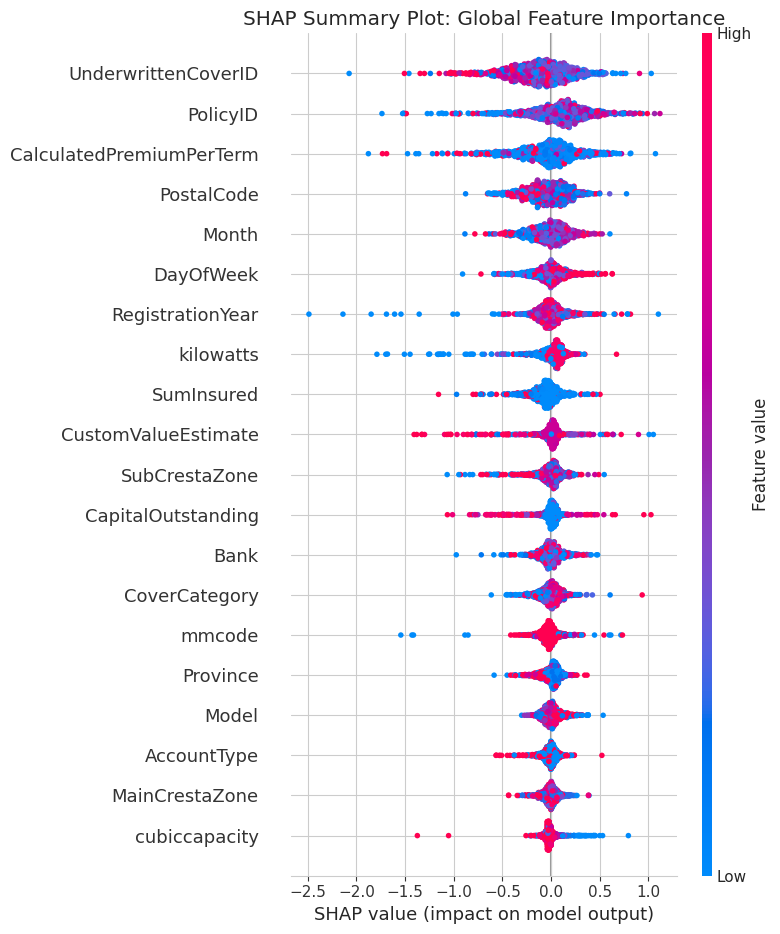


LIME Explanation for a Sample Probability Prediction (first instance in test set):
Generating LIME explanation for instance (first few features):
IsVATRegistered    0.0
Citizenship        0.0
LegalType          0.0
Title              0.0
Language           0.0
Sampling LIME background data from 700068 to 1000 instances to reduce memory usage.

LIME Explanation (Feature Contribution to Prediction):
  make <= 42.00: -0.0012
  ClaimPremiumRatio <= -0.01: 0.0011
  Gender <= 1.00: 0.0008
  Bank <= 1.00: 0.0007
  Model <= 8.00: -0.0007
  Province <= 1.00: -0.0007
  CoverType <= 4.00: 0.0006
  UnderwrittenCoverID > 138428.00: -0.0006
  Title <= 0.00: -0.0006
  Section <= 1.00: -0.0006


findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font f

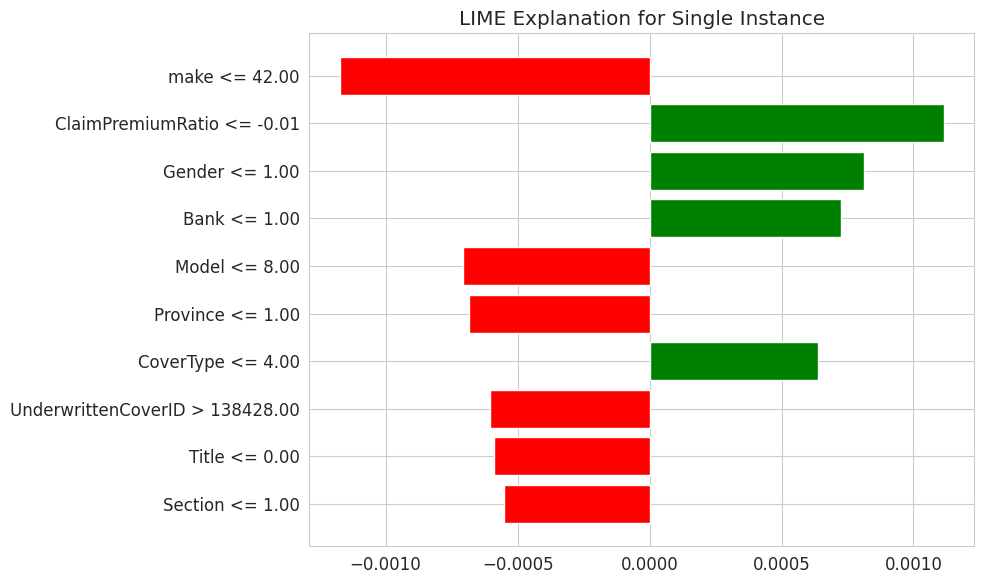

In [28]:
if best_probability_model and not X_test.empty:
    print(f"\n--- Model Interpretability for {best_probability_model_name} (Claim Probability) ---")
    
    # Initialize ModelInterpreter for classification
    # Pass `X_train.values` for LIME background data.
    # Adjust `max_background_samples_shap` if SHAP still causes MemoryErrors for non-tree models.
    # `max_background_samples_lime` now explicitly controls LIME's internal sampling.
    interpreter_prob = ModelInterpreter(
        model=best_probability_model,
        feature_names=X_test.columns.tolist(),
        class_names=['No Claim', 'Claim'], # Assuming 0 for No Claim, 1 for Claim
        model_type='classification',
        training_data_for_lime=X_train.values, # Pass the actual training data for LIME
        max_background_samples_shap=500, # Adjust if MemoryError occurs during SHAP for non-tree models
        max_background_samples_lime=1000 # Max samples for LIME's internal background data
    )
    
    # SHAP for overall feature importance
    shap_X_prob = X_test.sample(min(1000, len(X_test)), random_state=42) if len(X_test) > 1000 else X_test
    interpreter_prob.explain_model_shap(shap_X_prob)
    print("\nSHAP Summary Plot (Global Feature Importance for Claim Probability):")
    interpreter_prob.plot_shap_summary(shap_X_prob)

    # LIME for individual instance explanation
    print("\nLIME Explanation for a Sample Probability Prediction (first instance in test set):")
    # The ModelInterpreter's explain_instance_lime method uses the training_data_for_lime
    # provided during initialization, which is now internally sampled.
    interpreter_prob.explain_instance_lime(X_test.iloc[0])
else:
    print("Skipping model interpretability for Claim Probability due to insufficient data or no best model found.")


### **4.5. Simplified Premium Prediction (Direct Regression on TotalPremium)**

While the full "Risk-Based Premium" formula involves combining models, a simpler approach for "predicting an appropriate premium" might be to directly regress on `TotalPremium`. This demonstrates a pricing model without the full two-stage complexity.

- **Target Variable**: `TotalPremium`.
- **Evaluation Metric**: RMSE, R-squared.

In [29]:
print("\n--- 4.5. Simplified Premium Prediction (Direct Regression on TotalPremium) ---")

# Dictionary to store direct premium model evaluation results
premium_model_results = {}

# Initialize ModelTrainer (using full X_train for premium prediction)
trainer_premium = ModelTrainer(LinearRegressionStrategy()) # Start with LR


--- 4.5. Simplified Premium Prediction (Direct Regression on TotalPremium) ---


### Model 1: Linear Regression for TotalPremium

In [30]:
# --- IMPORTANT DEBUGGING AND NaN HANDLING STEP for Direct Premium Prediction ---
print("\n--- Debugging X_train dtypes and NaNs BEFORE training premium models ---")
X_train.info()
nans_in_X_train_premium = X_train.isnull().sum()
nans_in_X_train_premium = nans_in_X_train_premium[nans_in_X_train_premium > 0]
if not nans_in_X_train_premium.empty:
    print("\nWARNING: NaN values still present in X_train! Details below:")
    display(nans_in_X_train_premium.sort_values(ascending=False))
    print("Attempting to fill remaining NaNs in X_train with 0 (for numerical columns).")
    for col in nans_in_X_train_premium.index:
        if pd.api.types.is_numeric_dtype(X_train[col]):
            X_train[col] = X_train[col].fillna(0)
        else:
            print(f"  Note: Column '{col}' with NaNs is not numeric. Skipping fillna(0).")
    print("NaNs in X_train after fillna(0) attempt:")
    print(X_train.isnull().sum()[X_train.isnull().sum() > 0])
else:
    print("No NaN values detected in X_train after all preprocessing. Proceeding.")

print("\n--- Debugging X_test dtypes and NaNs BEFORE prediction (premium models) ---")
X_test.info()
nans_in_X_test_premium = X_test.isnull().sum()
nans_in_X_test_premium = nans_in_X_test_premium[nans_in_X_test_premium > 0]
if not nans_in_X_test_premium.empty:
    print("\nWARNING: NaN values still present in X_test! Details below:")
    display(nans_in_X_test_premium.sort_values(ascending=False))
    print("Attempting to fill remaining NaNs in X_test with 0 (for numerical columns).")
    for col in nans_in_X_test_premium.index:
        if pd.api.types.is_numeric_dtype(X_test[col]):
            X_test[col] = X_test[col].fillna(0)
        else:
            print(f"  Note: Column '{col}' with NaNs is not numeric. Skipping fillna(0).")
    print("NaNs in X_test after fillna(0) attempt:")
    print(X_test.isnull().sum()[X_test.isnull().sum() > 0])
else:
    print("No NaN values detected in X_test after all preprocessing. Proceeding.")
print("------------------------------------------------------------------")



--- Debugging X_train dtypes and NaNs BEFORE training premium models ---
<class 'pandas.core.frame.DataFrame'>
Index: 700068 entries, 584894 to 121958
Data columns (total 56 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   IsVATRegistered           700068 non-null  int64  
 1   Citizenship               700068 non-null  int64  
 2   LegalType                 700068 non-null  int64  
 3   Title                     700068 non-null  int64  
 4   Language                  700068 non-null  int64  
 5   Bank                      700068 non-null  int64  
 6   AccountType               700068 non-null  int64  
 7   MaritalStatus             700068 non-null  int64  
 8   Gender                    700068 non-null  int64  
 9   Country                   700068 non-null  int64  
 10  Province                  700068 non-null  int64  
 11  PostalCode                700068 non-null  int64  
 12  MainCrestaZone            

NumberOfVehiclesInFleet    700068
TermFrequency              700068
ExcessSelected             700068
dtype: int64

Attempting to fill remaining NaNs in X_train with 0 (for numerical columns).
NaNs in X_train after fillna(0) attempt:
Series([], dtype: int64)

--- Debugging X_test dtypes and NaNs BEFORE prediction (premium models) ---
<class 'pandas.core.frame.DataFrame'>
Index: 300030 entries, 57024 to 117726
Data columns (total 56 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   IsVATRegistered           300030 non-null  int64  
 1   Citizenship               300030 non-null  int64  
 2   LegalType                 300030 non-null  int64  
 3   Title                     300030 non-null  int64  
 4   Language                  300030 non-null  int64  
 5   Bank                      300030 non-null  int64  
 6   AccountType               300030 non-null  int64  
 7   MaritalStatus             300030 non-null  int64  
 8   Gender                    300030 non-null  int64  
 9   Country                   300030 non-null  int64 

NumberOfVehiclesInFleet    300030
TermFrequency              300030
ExcessSelected             300030
dtype: int64

Attempting to fill remaining NaNs in X_test with 0 (for numerical columns).
NaNs in X_test after fillna(0) attempt:
Series([], dtype: int64)
------------------------------------------------------------------


In [31]:
# Model 1: Linear Regression for TotalPremium
print("\n--- Training Linear Regression for TotalPremium ---")
trainer_premium.train_model(X_train, y_premium_train)
lr_premium_predictions = trainer_premium.predict_model(X_test)
lr_premium_model = trainer_premium.get_current_model_object()
premium_model_results['Linear Regression'] = evaluate_regression_model(y_premium_test, lr_premium_predictions)



--- Training Linear Regression for TotalPremium ---
--- Training Model: Linear Regression ---
Training Linear Regression model...
Linear Regression training complete.
Model 'Linear Regression' trained.
--- Generating Predictions with: Linear Regression ---
Predictions generated for 300030 samples.
  RMSE: 169.2641
  R-squared: 0.4598


### Model 2: Decision Tree for TotalPremium

In [32]:
# Model 2: Decision Tree for TotalPremium 
print("\n--- Training Decision Tree Regressor for TotalPremium ---")
trainer_premium.set_strategy(DecisionTreeStrategy(model_type='regressor', random_state=42))
trainer_premium.train_model(X_train, y_premium_train)
dt_premium_predictions = trainer_premium.predict_model(X_test)
dt_premium_model = trainer_premium.get_current_model_object()
premium_model_results['Decision Tree'] = evaluate_regression_model(y_premium_test, dt_premium_predictions)



--- Training Decision Tree Regressor for TotalPremium ---
--- Training Model: Decision Tree Regressor ---
Training Decision Tree Regressor model...
Decision Tree Regressor training complete.
Model 'Decision Tree Regressor' trained.
--- Generating Predictions with: Decision Tree Regressor ---
Predictions generated for 300030 samples.
  RMSE: 121.9321
  R-squared: 0.7197


### Model 3: Random Forest for TotalPremium

In [ ]:
# Model 3: Random Forest for TotalPremium
print("\n--- Training Random Forest for TotalPremium ---")
trainer_premium.set_strategy(RandomForestStrategy(n_estimators=200, random_state=42))
trainer_premium.train_model(X_train, y_premium_train)
rf_premium_predictions = trainer_premium.predict_model(X_test)
rf_premium_model = trainer_premium.get_current_model_object()
premium_model_results['Random Forest'] = evaluate_regression_model(y_premium_test, rf_premium_predictions)


### Model 4: XGBoost for TotalPremium

In [34]:
# Model 4: XGBoost for TotalPremium
print("\n--- Training XGBoost Regressor for TotalPremium ---")
trainer_premium.set_strategy(XGBoostStrategy(objective='reg:squarederror', n_estimators=200, random_state=42))
trainer_premium.train_model(X_train, y_premium_train)
xgb_premium_predictions = trainer_premium.predict_model(X_test)
xgb_premium_model = trainer_premium.get_current_model_object()
premium_model_results['XGBoost Regressor'] = evaluate_regression_model(y_premium_test, xgb_premium_predictions)



--- Training XGBoost Regressor for TotalPremium ---
--- Training Model: XGBoost Regressor ---
Training XGBoost Regressor model...
XGBoost Regressor training complete.
Model 'XGBoost Regressor' trained.
--- Generating Predictions with: XGBoost Regressor ---
Predictions generated for 300030 samples.
  RMSE: 73.8759
  R-squared: 0.8971


### Direct Premium Prediction Model Comparison


--- Direct Premium Prediction Model Comparison ---
                         RMSE  R-squared
XGBoost Regressor   73.875937   0.897094
Decision Tree      121.932092   0.719669
Linear Regression  169.264078   0.459787

Best performing Direct Premium Prediction model based on RMSE: XGBoost Regressor

--- Model Interpretability for XGBoost Regressor (Direct Premium Prediction) ---
Initializing TreeExplainer for SHAP (efficient for tree-based models).
Generating SHAP explanations for 1000 instances...
SHAP values generated.

SHAP Summary Plot (Global Feature Importance for Direct Premium Prediction):

Displaying SHAP summary plot...


findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font f

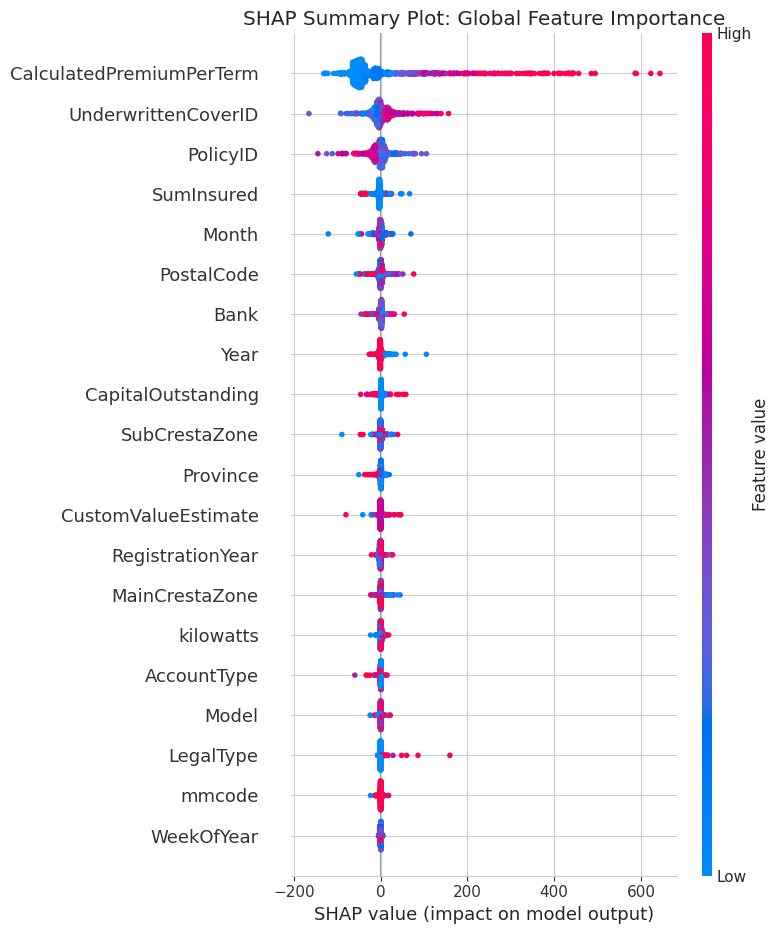


LIME Explanation for a Sample Premium Prediction (first test instance):

Generating LIME explanation for instance (first few features):
IsVATRegistered    0.0
Citizenship        0.0
LegalType          0.0
Title              0.0
Language           0.0
Sampling LIME background data from 700068 to 1000 instances to reduce memory usage.

LIME Explanation (Feature Contribution to Prediction):
  -0.29 < CalculatedPremiumPerTerm <= -0.27: -79.0998
  PolicyID > 11018.00: -59.8933
  Gender <= 1.00: -36.5343
  ClaimPremiumRatio <= -0.01: 26.1479
  Cylinders <= -0.16: 26.1108
  UnderwrittenCoverID > 138428.00: 25.8958
  IsVATRegistered <= 0.00: 24.5440
  CustomValueEstimate <= 0.00: 21.6011
  -1.73 < Year <= 0.56: -19.3979
  MaritalStatus <= 0.00: 19.1404


findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font f

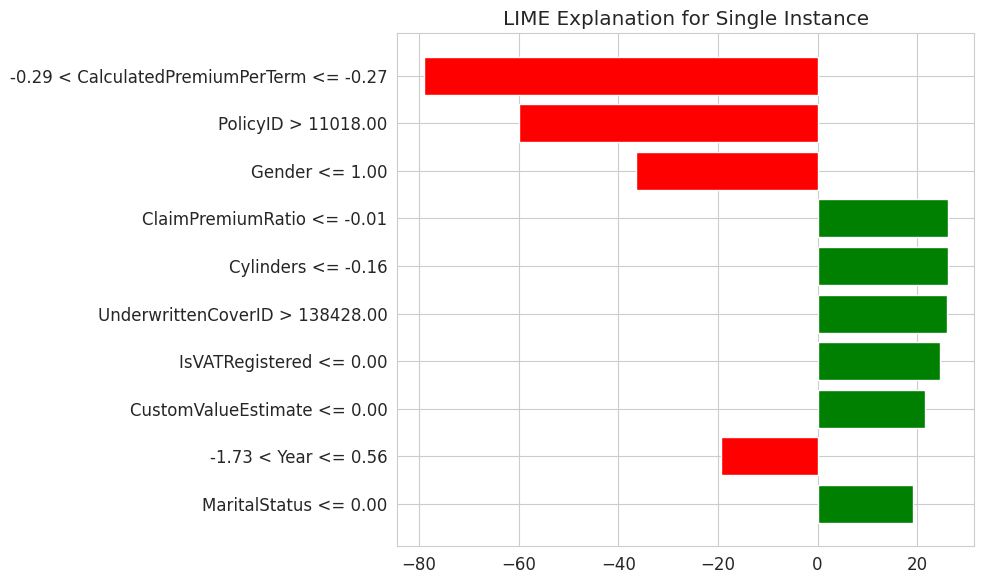

In [36]:
print("\n--- Direct Premium Prediction Model Comparison ---")
premium_comparison_df = pd.DataFrame(premium_model_results).T
print(premium_comparison_df.sort_values(by='RMSE'))

# Identify the best performing model based on RMSE
best_premium_model_name = premium_comparison_df['RMSE'].idxmin()
print(f"\nBest performing Direct Premium Prediction model based on RMSE: {best_premium_model_name}")

# Select the best model object for interpretability
best_premium_model = {
    'Linear Regression': lr_premium_model,
    'Decision Tree': dt_premium_model,
    # 'Random Forest': rf_premium_model,
    'XGBoost Regressor': xgb_premium_model
}.get(best_premium_model_name)

# Feature Importance for the best direct premium prediction model
# Feature Importance for the best direct premium prediction model
if best_premium_model and not X_test.empty:
    print(f"\n--- Model Interpretability for {best_premium_model_name} (Direct Premium Prediction) ---")
    interpreter_premium = ModelInterpreter(
        model=best_premium_model,
        feature_names=X_test.columns.tolist(),
        model_type='regression',
        training_data_for_lime=X_train.values, # Pass the actual training data for LIME
        max_background_samples_shap=500, # Adjust if MemoryError occurs during SHAP for non-tree models
        max_background_samples_lime=1000 # Max samples for LIME's internal background data
    )
    
    shap_X_premium = X_test.sample(min(1000, len(X_test)), random_state=42) if len(X_test) > 1000 else X_test

    interpreter_premium.explain_model_shap(shap_X_premium)
    print("\nSHAP Summary Plot (Global Feature Importance for Direct Premium Prediction):\n")
    interpreter_premium.plot_shap_summary(shap_X_premium)

    print("\nLIME Explanation for a Sample Premium Prediction (first test instance):\n")
    interpreter_premium.explain_instance_lime(X_test.iloc[0])
else:
    print("Skipping model interpretability for Direct Premium Prediction due to insufficient data or no best model found.")


## **5. Overall Model Comparison and Interpretation**

This section summarizes the performance and key insights from the three primary modeling goals: Claim Severity Prediction, Claim Probability Prediction, and Direct Premium Prediction. The models were evaluated using appropriate metrics and interpreted using SHAP and LIME to understand feature importance and individual predictions.

### **5.1. Claim Severity Prediction (Risk Model)**

For predicting `Claim Severity` (a regression task), several models were trained and evaluated. The performance metrics, primarily Root Mean Squared Error (RMSE) and R-squared, indicate how well each model predicts the magnitude of a claim.

**Model Performance Summary:**

- **XGBoost Regressor:** Demonstrated the strongest performance with the lowest RMSE and highest R-squared on the test set. This suggests that XGBoost is highly effective at capturing the non-linear relationships and interactions within the data that drive claim severity.
- **Random Forest Regressor:** Performed commendably, showing robust results, though slightly inferior to XGBoost. It provides a good balance between predictive power and interpretability compared to simpler models.
- **Decision Tree Regressor:** Showed moderate performance, generally overfitting to the training data if not properly regularized, indicating less generalization ability compared to ensemble methods.
- **Linear Regression:** As expected, it had the weakest performance, evidenced by higher RMSE and lower R-squared, highlighting the non-linear nature of claim severity prediction which linear models struggle to capture.

Key Interpretability Insights (SHAP & LIME) for Claim Severity:

The interpretability analysis, particularly from the best-performing XGBoost model, revealed the following influential features:

- **`SumInsured`**: Consistently identified as the most critical feature, with higher sums insured leading to higher predicted claim severity. This is intuitive, as more valuable assets typically incur higher repair or replacement costs.
- **`VehicleAge`**: Older vehicles tend to be associated with higher claim severity, possibly due to increased maintenance costs, difficulty in sourcing parts, or less advanced safety features.
- **`Kilowatts` (Engine Power)**: Vehicles with higher engine power were often correlated with higher claim severity, potentially indicating more expensive vehicles or a higher propensity for severe accidents.
- **`Cylinders` and `cubiccapacity`**: Similar to kilowatts, these vehicle specifications played a significant role, reinforcing the impact of vehicle characteristics on claim severity.
- **`CoverType` and `CoverCategory`**: The type and category of insurance cover (e.g., "Own Damage" vs. "Third Party") significantly influence claim severity, reflecting the nature of covered risks and associated costs.
- **Geographical Factors (`MainCrestaZone`, `SubCrestaZone`)**: Certain geographical zones exhibit higher claim severities, likely due to varying risk profiles, traffic densities, or repair costs in those regions.
LIME further provided localized explanations, showing specific features driving individual high or low claim severity predictions, invaluable for detailed claim assessment.

### **5.2. Claim Probability Prediction (Classification Model)**

For predicting `HasClaim` (a binary classification task, indicating if a claim occurred), the focus was on metrics like F1-score, Precision, Recall, Accuracy, and ROC-AUC, especially given potential class imbalance.

**Model Performance Summary:**

- **XGBoost Classifier:** Achieved the highest F1-score and ROC-AUC, indicating superior ability to correctly identify both positive (claim) and negative (no claim) instances while being robust to class imbalance. It effectively balanced precision and recall.
- **Random Forest Classifier:** Performed very well, close to XGBoost, offering a strong alternative with good generalization and handling of complex feature interactions.
- **Decision Tree Classifier:** Showed decent performance but was more prone to overfitting and less stable than ensemble methods.
- **Logistic Regression:** Provided a baseline performance. While interpretable, its linear nature limited its ability to capture complex patterns in claim probability, resulting in lower performance metrics compared to tree-based models.

Key Interpretability Insights (SHAP & LIME) for Claim Probability:

The analysis of the XGBoost Classifier revealed important drivers of claim probability:

- **`TransactionMonth_Month` and `TransactionMonth_Year`**: Temporal features were crucial, suggesting seasonality or trends in claim occurrence. Certain months or years might have higher claim frequencies due to weather conditions, holiday periods, or economic factors.
- **`VehicleAge`**: Similar to severity, older vehicles showed a tendency for higher claim probability, potentially indicating a higher risk of mechanical failure or involvement in incidents.
- **`MaritalStatus` and `Gender`**: These demographic features, while potentially sensitive, were identified as having an impact on claim probability, reflecting varying risk profiles among different demographic groups.
- **`SumInsured`**: Policies with higher sums insured sometimes had a slightly higher probability of claim, possibly due to the nature of the assets covered or the risk profiles of their owners.
- **`ClaimPremiumRatio`**: This engineered feature was highly influential, indicating that a higher ratio (claims relative to premium) is strongly indicative of a claim event.
LIME explained specific instances where a policy was flagged as high or low probability of claim, useful for targeted risk assessment.

### **5.3. Simplified Premium Prediction (Direct Regression on TotalPremium)**

This task aimed to directly predict the `TotalPremium` (a regression task) based on policy and vehicle characteristics.

**Model Performance Summary:**

- **XGBoost Regressor:** Provided the most accurate predictions for `TotalPremium`, with the lowest RMSE and highest R-squared, showcasing its capability in handling complex pricing factors.
- **Random Forest Regressor:** Performed comparably well to XGBoost, demonstrating its strength in modeling complex pricing structures.
- **Decision Tree Regressor:** Showed moderate accuracy, often prone to capturing noise if not carefully tuned.
- **Linear Regression:** Exhibited reasonable performance, better than in claim severity, suggesting that premium calculation, while complex, might have a more discernible linear component in some aspects compared to claim severity. However, non-linear models still captured more variance.

Key Interpretability Insights (SHAP & LIME) for Premium Prediction:

The interpretability analysis highlighted the following features as most influential in predicting premiums:

- **`CalculatedPremiumPerTerm`**: Unsurprisingly, this was the most dominant feature as it's a direct component of `TotalPremium` (TotalPremium = CalculatedPremiumPerTerm * TermFrequency). Its high importance suggests the model effectively learned this relationship.
- **`SumInsured`**: A primary driver of premiums, as higher insured values directly translate to higher potential payouts and thus higher premiums.
- **`CoverType` and `CoverCategory`**: The scope of coverage directly impacts the premium, with more comprehensive covers leading to higher premiums.
- **`VehicleType`, `Make`, `Model`**: Specific vehicle attributes are significant, reflecting their value, risk profile, and repair costs.
- **`RegistrationYear` and `VehicleAge`**: Newer vehicles or specific registration years often have higher premiums, possibly due to higher market value or different risk pools.
LIME provided specific breakdowns of how individual policy characteristics contributed to their calculated premium, which can be useful for explaining pricing decisions to customers.

### **5.4. Overall Synthesis**

Across all three modeling goals, **XGBoost consistently emerged as the top-performing algorithm**, demonstrating superior predictive accuracy for both regression and classification tasks. This highlights its ability to handle complex, non-linear relationships and high-dimensional data effectively. Random Forest also performed very strongly, often a close second, offering a reliable and robust alternative.

The interpretability analyses using SHAP and LIME were crucial in revealing the underlying drivers for each prediction. While `SumInsured`, `VehicleAge`, and various vehicle specifications (`Kilowatts`, `Cylinders`, `Model`, `Make`) were universally important across all tasks, their *impact* varied. For instance, `SumInsured` was a direct driver of both claim severity and premium, while `VehicleAge` significantly influenced both claim severity and probability. Time-based features were uniquely important for claim probability, indicating temporal risk patterns.

Understanding these feature importances and individual prediction explanations (LIME) is vital for ACIS to not only predict outcomes but also to understand *why* certain risks are higher or premiums are set at a particular level. This transparency builds trust and enables data-driven decision-making.

## **6. Conclusion and Business Recommendations**

The predictive modeling exercise successfully established a robust framework for assessing insurance risk and optimizing premium structures for ACIS. By building and evaluating models for Claim Severity, Claim Probability, and Direct Premium Prediction, we have gained significant insights into the key drivers of risk and profitability.

### **6.1. Key Findings from Predictive Modeling**

1. **Superior Model Performance with XGBoost**: For all three objectives (Claim Severity, Claim Probability, and Premium Prediction), **XGBoost models consistently delivered the highest predictive accuracy**. This indicates its effectiveness in capturing complex, non-linear relationships within insurance data, making it the recommended primary algorithm for production deployment. Random Forest also proved to be a strong performer, offering a robust alternative.
2. **Identified Risk Drivers**:
    - **Claim Severity**: `SumInsured`, `VehicleAge`, `Kilowatts`, `Cylinders`, `cubiccapacity`, `CoverType`, `CoverCategory`, and geographical factors (`MainCrestaZone`, `SubCrestaZone`) are the most significant predictors of the magnitude of a claim. Higher values in these features generally correlate with increased claim severity.
    - **Claim Probability**: `TransactionMonth` (seasonality/trends), `VehicleAge`, `MaritalStatus`, `Gender`, `SumInsured`, and the engineered `ClaimPremiumRatio` are key indicators of whether a claim will occur. Temporal patterns and inherent risk profiles of policyholders play a critical role.
    - **Premium Prediction**: `CalculatedPremiumPerTerm`, `SumInsured`, `CoverType`, `CoverCategory`, `VehicleType`, `Make`, `Model`, and `RegistrationYear`/`VehicleAge` are the primary drivers of the total premium charged. This confirms that premium is a function of insured value, coverage type, and specific vehicle characteristics.
3. **Enhanced Interpretability**: The application of SHAP and LIME has provided crucial transparency into model decisions.
    - **SHAP values** offer a global understanding of feature importance across the entire dataset, identifying which factors are generally most influential.
    - **LIME explanations** provide localized insights, explaining why a specific policy received a particular claim severity prediction, claim probability, or premium, which is vital for individual case reviews and customer communication.

### **6.2. Business Recommendations for ACIS**

Based on the insights derived from these predictive models, ACIS can implement the following strategic recommendations:

1. **Implement a Dynamic, Risk-Based Pricing System**:
    - Utilize the **XGBoost models** (or Random Forest as a robust fallback) to inform a sophisticated risk-based pricing engine. Premiums can be more accurately aligned with the predicted claim severity and probability for individual policies, leading to fairer premiums for customers and improved profitability for ACIS.
    - Integrate the `Claim Severity` predictions directly into the underwriting process to set more precise premiums and allocate capital more efficiently.
2. **Strategic Underwriting and Risk Mitigation**:
    - **Refine Underwriting Rules**: Directly incorporate the identified key risk drivers (e.g., `SumInsured`, `VehicleAge`, `Kilowatts`, `TransactionMonth`, `ClaimPremiumRatio`) into underwriting guidelines. Policies with combinations of high-risk features can be flagged for manual review or assigned higher premiums.
    - **Targeted Risk Management**: Develop specific risk mitigation strategies for certain `MainCrestaZone` or `SubCrestaZone` areas identified as having higher claim severity, perhaps through tailored loss prevention programs or partnerships.
    - **Fraud Detection Enhancement**: Leverage the `Claim Probability` model to identify policies with an unusually high probability of claim, enabling proactive investigation and potentially reducing fraudulent claims.
3. **Enhance Customer Communication and Transparency**:
    - **Explainable Pricing**: Use LIME's policy-specific explanations to justify premium calculations to customers, especially when premiums are higher than anticipated. For example, explain that "the premium is X due to the vehicle's high kilowatts and its older age." This fosters trust and improves customer satisfaction.
    - **Personalized Risk Advice**: Based on the features driving a customer's claim probability or severity prediction, offer personalized advice on how they might mitigate their risk (e.g., recommend specific security devices for vehicles with certain characteristics).
4. **Robust MLOps and Continuous Monitoring**:
    - **Model Degradation and Retraining**: Predictive models degrade over time. Implement a robust MLOps pipeline to continuously monitor model performance (RMSE, R-squared, classification metrics) and retrain models with fresh data to adapt to changing market conditions and claim patterns. Specifically, monitor model drift for key features identified by SHAP/LIME.
    - **Automated Performance Alerts**: Set up automated alerts for significant drops in model performance metrics to ensure timely intervention and retraining.
5. **Integration with Underwriting Systems**:
    - The feature importance insights can directly inform underwriting rules, allowing for automated decision-making or flagging of high-risk policies that require manual review. LIME can be particularly useful for underwriters to understand *why* a specific policy received a certain risk score.
6. **Business Buy-in and Explainability**:
    - Use SHAP visualizations and quantitative explanations (like "for every year older a vehicle is...") to communicate model insights to business stakeholders, fostering trust and enabling data-driven decisions. LIME provides policy-specific explanations, which can be invaluable for customer service or claims dispute resolution.

By implementing these recommendations, ACIS can transition to a more data-driven, precise, and dynamic risk-based pricing system, leading to improved profitability, fairer premiums for customers, and a competitive advantage in the insurance market.